In [15]:
import sys, os
from collections import namedtuple
import csv
import ast
import re
import math

from tqdm import tqdm

import openai, anthropic
import backoff
import tiktoken

from langchain.chat_models import ChatOpenAI
from langchain.chat_models import ChatAnthropic
from langchain.chat_models import ChatFireworks
from langchain.prompts.chat import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    AIMessagePromptTemplate,
    HumanMessagePromptTemplate,
)
from langchain.schema import (
    AIMessage,
    HumanMessage,
    SystemMessage
)

import mistune

In [2]:
import importlib

importlib.reload(openai)
import langchain
import langchain.chat_models
importlib.reload(langchain)

<module 'langchain' from '/mnt/lofn0/amiceli/adversarial_code_gen/surtr-env/lib/python3.10/site-packages/langchain/__init__.py'>

In [26]:
oai_api_key_file =       "path/to/openai_key"
fireworks_api_key_file =       "path/to/fireworks_key"

with open(oai_api_key_file, "r") as api_key_fs:
    os.environ["OPENAI_API_KEY"] = api_key_fs.read().strip()
    
with open(fireworks_api_key_file, "r") as api_key_fs:
    os.environ["FIREWORKS_API_KEY"] = api_key_fs.read().strip()

In [4]:
# change accordingly
fireworks_account_name = "fireworks_account_name"
fireworks_deepseek_r1_distill_llama_7b_model_id="ID"
fireworks_deepseek_r1_distill_llama_7b_finetuned_model_fullpath="accounts/fireworks_account_name/deployedModels/ft-sineq-deepseek-r1-distill-llama-70b-ID"

In [5]:
test_set_file = "../cc_4_0_licensed/python_builtins_swap.csv" # Path to test set

In [6]:
test_set = []
with open(test_set_file, "r") as in_fs:
    reader = csv.reader(in_fs)
    for i, row in enumerate(reader):
        if i == 0:
            continue # skip header
        example = {"prompt": row[0], "classes": ast.literal_eval(row[1]), "answer_index": int(row[2])}
        test_set.append(example)

In [7]:
prompt_template = \
"""
Consider the following Python programs:

Program 1:

{program_1}

Program 2:

{program_2}

Which program is more likely to be correct? Write only the number of the program and nothing else.
"""

prompt_template_cot = \
"""
Consider the following Python programs:

Program 1:

{program_1}

Program 2:

{program_2}

Which program is more likely to be correct? Think step by step and answer with the number of the program.
"""

prompt_template_deepseek_r1 = \
"""
Consider the following Python programs:

Program 1:

{program_1}

Program 2:

{program_2}

Which program is more likely to be correct? Answer with the number of the program. """

In [8]:
batch_size = 20 # note: actual submitted batches are twice as big since each example is sumbitted in two variants
max_tokens_per_example = 16000 # Computed using tiktoken, not including the system prompt, assuming gpt-4o-mini-2024-07-18

In [9]:
tokenizer = tiktoken.encoding_for_model('gpt-4o-mini')

In [10]:
@backoff.on_exception(backoff.expo, Exception)
def chat_llm_batch(chat_model, batch_messages, **kwargs):
    try:
        return chat_model.generate(batch_messages, **kwargs)
    except Exception as exc:
        print(exc, file=sys.stderr)
        raise(exc)

def eval_chat_model_batch(chat_model, batch, switch_order):
    b_accuracy, b_num_valid = 0, 0
    batch_messages = []
    y_batch = []
    for example in batch:
        y = example["answer_index"]
        if switch_order:
            y = 1 - y
        x = prompt_template.format(
            program_1 = example["prompt"] + example["classes"][1-y].rstrip() + "\n",
            program_2 = example["prompt"] + example["classes"][y].rstrip() + "\n")
        if len(tokenizer.encode(x)) > max_tokens_per_example:
            # too long, skip
            continue
        x_messages = [
            SystemMessage(content="You are a helpful assistant."),
            HumanMessage(content=x)]
        batch_messages.append(x_messages)
        y_batch.append(y)
    llm_batch_response = chat_llm_batch(chat_model, batch_messages)
    for i, gen in enumerate(llm_batch_response.generations):
        match = re.search(r'(\d+)', gen[0].text)
        if match is None:
            continue
        gen_class = int(match.group(1)) - 1 # generated class ids should be returned by the llm in the 1, 2 range
        if (gen_class < 0) or (gen_class > 1):
            continue
        if gen_class == y:
            b_accuracy += 1
        b_num_valid += 1
    return b_accuracy, b_num_valid   

cot_system_message = \
"""You are an expert computer scientist. Your task is to take two Python 3.10 programs and determine which one of them is more likely to be correct. You should just evaluate their semantic correctness, not the code style.
Think step by step before writing your program. Use the following Markdown format, making sure that the following sections are delimited by level 1 headings, since they will have to be automatically parsed:
# Analysis
step by step analysis. This section can include sub-headings and code blocks
# Answer
either 1 if Program 1 is more likely to be correct or 2 if more likely to be correct. Do not write anything else in this section.
"""

def eval_chat_model_batch_cot(chat_model, batch, switch_order):
    b_accuracy, b_num_valid = 0, 0
    batch_messages = []
    y_batch = []
    for example in batch:
        y = example["answer_index"]
        if switch_order:
            y = 1 - y
        x = prompt_template_cot.format(
            program_1 = example["prompt"] + example["classes"][1-y].rstrip() + "\n",
            program_2 = example["prompt"] + example["classes"][y].rstrip() + "\n")
        if len(tokenizer.encode(x)) > max_tokens_per_example:
            # too long, skip
            continue
        x_messages = [
            SystemMessage(content=cot_system_message),
            HumanMessage(content=x)]
        batch_messages.append(x_messages)
        y_batch.append(y)
    llm_batch_response = chat_llm_batch(chat_model, batch_messages)

    markdown = mistune.create_markdown(renderer='ast')
    for i, gen in enumerate(llm_batch_response.generations):
        response_text = gen[0].text
        try:
            parsed_markdown = markdown(response_text)
            answer_j = [j for j, e in enumerate(parsed_markdown) if (e['type'] == "heading") and (e["children"][0]["raw"] == "Answer")][0]
            answer_text_list = [e["children"][0]["raw"] for e in parsed_markdown[answer_j:] if (e['type'] == "paragraph") and ("children" in e)]
            answer_text = answer_text_list[0]
        except Exception as exc:
            # Invalid markdown
            continue
        match = re.search(r'(\d+)', answer_text)
        if match is None:
            continue
        gen_class = int(match.group(1)) - 1 # generated class ids should be returned by the llm in the 1, 2 range
        if (gen_class < 0) or (gen_class > 1):
            continue
        if gen_class == y:
            b_accuracy += 1
        b_num_valid += 1
    return b_accuracy, b_num_valid   

def eval_chat_model_batch_deepseek_r1(chat_model, batch, switch_order):
    b_accuracy, b_num_valid = 0, 0
    batch_messages = []
    y_batch = []
    for example in batch:
        y = example["answer_index"]
        if switch_order:
            y = 1 - y
        x = prompt_template_deepseek_r1.format(
            program_1 = example["prompt"] + example["classes"][1-y].rstrip() + "\n",
            program_2 = example["prompt"] + example["classes"][y].rstrip() + "\n")
        x += "Please reason step by step, and put your final answer within \\boxed{}."
        if len(tokenizer.encode(x)) > max_tokens_per_example:
            # too long, skip
            continue
        x_messages = [
            HumanMessage(content=x)]
        batch_messages.append(x_messages)
        y_batch.append(y)
    llm_batch_response = chat_llm_batch(chat_model, batch_messages)
    for i, gen in enumerate(llm_batch_response.generations):
        match = re.search(r'\\boxed\{(-?\d+)\}', gen[0].text) # DeepSeek-r1 output within \boxed{}
        if match is None:
            continue
        gen_class = int(match.group(1)) - 1 # generated class ids should be returned by the llm in the 1, 2 range
        if (gen_class < 0) or (gen_class > 1):
            continue
        if gen_class == y:
            b_accuracy += 1
        b_num_valid += 1
    return b_accuracy, b_num_valid   


def eval_chat_model(chat_model, test_set, cot_mode=False, fraction_to_test = 1.0, deepseek_mode=False):
    if deepseek_mode:
        batch_eval_func = eval_chat_model_batch_deepseek_r1
    elif cot_mode:
        batch_eval_func = eval_chat_model_batch_cot
    else:
        batch_eval_func = eval_chat_model_batch
    raw_total_accuracy, num_valid, num_examples = 0, 0, 0
    batch = []
    effective_test_set_size = min(round(fraction_to_test * len(test_set)), len(test_set))
    for i in tqdm(range(effective_test_set_size + 1)):
        if (i >= effective_test_set_size) or (len(batch) >= batch_size):
            b_accuracy, b_num_valid = batch_eval_func(chat_model, batch, False)
            raw_total_accuracy += b_accuracy
            num_valid += b_num_valid
            num_examples += len(batch)
            b_accuracy, b_num_valid = batch_eval_func(chat_model, batch, True)
            raw_total_accuracy += b_accuracy
            num_valid += b_num_valid
            num_examples += len(batch)
            batch = []
        if i < effective_test_set_size:
            batch.append(test_set[i])
    total_accuracy = float(raw_total_accuracy) / float(num_examples)
    total_accuracy_on_valid = float(raw_total_accuracy) / float(num_valid)
    return {
        "raw_total_accuracy": raw_total_accuracy,
        "total_accuracy": total_accuracy,
        "total_accuracy_on_valid": total_accuracy_on_valid,
        "num_valid": num_valid,
        "num_examples": num_examples}

In [21]:
eval_results = {}

In [22]:
model_name="gpt-4o-mini-2024-07-18" # Untrained gpt-4o-mini
chat = ChatOpenAI(model_name=model_name, temperature=0.0)
print(model_name)
chat_eval = eval_chat_model(chat, test_set)
print(chat_eval)
print("----")
eval_results[model_name] = chat_eval

/tmp/ipykernel_1432321/3865214318.py:2: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  chat = ChatOpenAI(model_name=model_name, temperature=0.0)


gpt-4o-mini-2024-07-18


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1001/1001 [17:08<00:00,  1.03s/it]

{'raw_total_accuracy': 33, 'total_accuracy': 0.0165, 'total_accuracy_on_valid': 0.0165, 'num_valid': 2000, 'num_examples': 2000}
----


In [23]:
model_name="ft:gpt-4o-mini-2024-07-18:uedin:semantic-inequiv-bob-run-0-round-6-generation-0:AyS2gJFd" # gpt-4o-mini finetuned as 1st gen "Bob" evaluator
chat = ChatOpenAI(model_name=model_name, temperature=0.0)
print(model_name)
chat_eval = eval_chat_model(chat, test_set)
print(chat_eval)
print("----")
eval_results[model_name] = chat_eval

ft:gpt-4o-mini-2024-07-18:uedin:semantic-inequiv-bob-run-0-round-6-generation-0:AyS2gJFd


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1001/1001 [21:12<00:00,  1.27s/it]

{'raw_total_accuracy': 107, 'total_accuracy': 0.0535, 'total_accuracy_on_valid': 0.0535, 'num_valid': 2000, 'num_examples': 2000}
----


In [80]:
model_name="gpt-4o-mini-2024-07-18" # Untrained gpt-4o-mini in CoT mode
chat = ChatOpenAI(model_name=model_name, temperature=0.0)
print(model_name)
chat_eval = eval_chat_model(chat, test_set, cot_mode=True)
print(chat_eval)
print("----")
eval_results["cot_"+model_name] = chat_eval

gpt-4o-mini-2024-07-18


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1001/1001 [4:34:47<00:00, 16.47s/it]

{'raw_total_accuracy': 38, 'total_accuracy': 0.019, 'total_accuracy_on_valid': 0.019, 'num_valid': 2000, 'num_examples': 2000}
----


In [81]:
model_name="ft:gpt-4o-mini-2024-07-18:uedin:semantic-inequiv-bob-run-0-round-6-generation-0:AyS2gJFd" # gpt-4o-mini finetuned as 1st gen "Bob" evaluator in CoT mode
chat = ChatOpenAI(model_name=model_name, temperature=0.0)
print(model_name)
chat_eval = eval_chat_model(chat, test_set, cot_mode=True)
print(chat_eval)
print("----")
eval_results["cot_"+model_name] = chat_eval

ft:gpt-4o-mini-2024-07-18:uedin:semantic-inequiv-bob-run-0-round-6-generation-0:AyS2gJFd


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1001/1001 [3:35:47<00:00, 12.94s/it]

{'raw_total_accuracy': 46, 'total_accuracy': 0.023, 'total_accuracy_on_valid': 0.023, 'num_valid': 2000, 'num_examples': 2000}
----


In [101]:
model_name="o3-mini-2025-01-31" # Untrained o3-mini
chat = ChatOpenAI(model_name=model_name, temperature=1)
print(model_name)
chat_eval = eval_chat_model(chat, test_set)
print(chat_eval)
print("----")
eval_results[model_name] = chat_eval

o3-mini-2025-01-31


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1001/1001 [4:10:03<00:00, 14.99s/it]

{'raw_total_accuracy': 682, 'total_accuracy': 0.341, 'total_accuracy_on_valid': 0.341, 'num_valid': 2000, 'num_examples': 2000}
----


In [109]:
model_name="o1-2024-12-17" # Untrained o1
chat = ChatOpenAI(model_name=model_name, temperature=1)
print(model_name)
chat_eval = eval_chat_model(chat, test_set, fraction_to_test=0.1)
print(chat_eval)
print("----")
eval_results[model_name] = chat_eval

o1-2024-12-17


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [1:24:40<00:00, 50.30s/it]

{'raw_total_accuracy': 115, 'total_accuracy': 0.575, 'total_accuracy_on_valid': 0.575, 'num_valid': 200, 'num_examples': 200}
----


In [164]:
model_name="accounts/fireworks/models/deepseek-r1" # Untrained DeepSeek-r1
chat = ChatFireworks(
    model="accounts/fireworks/models/deepseek-r1",
    temperature=0.6,
    timeout=None,
    max_retries=2,
    max_tokens=6000,
)
print(model_name)
chat_eval = eval_chat_model(chat, test_set, fraction_to_test=0.1, deepseek_mode=True)
print(chat_eval)
print("----")
eval_results["deepseek-r1"] = chat_eval

accounts/fireworks/models/deepseek-r1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [3:07:23<00:00, 111.32s/it]

{'raw_total_accuracy': 188, 'total_accuracy': 0.94, 'total_accuracy_on_valid': 0.9740932642487047, 'num_valid': 193, 'num_examples': 200}
----


In [167]:
model_name="o3-mini-2025-01-31" # Untrained o3-mini with DeepSeek-style CoT prompt
chat = ChatOpenAI(model_name=model_name, temperature=1)
print(model_name)
chat_eval = eval_chat_model(chat, test_set, deepseek_mode=True)
print(chat_eval)
print("----")
eval_results["ds_"+model_name] = chat_eval

o3-mini-2025-01-31


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1001/1001 [7:01:57<00:00, 25.29s/it]

{'raw_total_accuracy': 924, 'total_accuracy': 0.462, 'total_accuracy_on_valid': 0.4626940410615924, 'num_valid': 1997, 'num_examples': 2000}
----


In [168]:
model_name="o1-2024-12-17" # Untrained o1 with DeepSeek-style CoT prompt
chat = ChatOpenAI(model_name=model_name, temperature=1)
print(model_name)
chat_eval = eval_chat_model(chat, test_set, fraction_to_test=0.1, deepseek_mode=True)
print(chat_eval)
print("----")
eval_results["ds_"+model_name] = chat_eval

o1-2024-12-17


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [2:41:25<00:00, 95.90s/it]

{'raw_total_accuracy': 144, 'total_accuracy': 0.72, 'total_accuracy_on_valid': 0.72, 'num_valid': 200, 'num_examples': 200}
----


In [176]:
model_name="deepseek-r1-distill-llama-70b" # Untrained DeepSeek-r1-distill-llama-70b
chat = ChatFireworks(
    model=f"accounts/{fireworks_account_name}/deployedModels/deepseek-r1-distill-llama-70b-{fireworks_deepseek_r1_distill_llama_7b_model_id}",
    temperature=0.6,
    timeout=None,
    max_retries=2,
    max_tokens=6000,
)
print(model_name)
chat_eval = eval_chat_model(chat, test_set, fraction_to_test=0.1, deepseek_mode=True)
print(chat_eval)
print("----")
eval_results[model_name] = chat_eval

deepseek-r1-distill-llama-70b


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [3:01:39<00:00, 107.91s/it]

{'raw_total_accuracy': 149, 'total_accuracy': 0.745, 'total_accuracy_on_valid': 0.7563451776649747, 'num_valid': 197, 'num_examples': 200}
----


In [16]:
# Failed run
model_name="ft-sineq-deepseek-r1-distill-llama-70b" # DeepSeek-r1-distill-llama-70b finetuned as 1st gen "Bob" evaluator, with data reformatted in DeepSeek style
chat = ChatFireworks(
    model=fireworks_deepseek_r1_distill_llama_7b_finetuned_model_fullpath,
    temperature=0.6,
    timeout=None,
    max_retries=2,
    max_tokens=6000,
)
print(model_name)
chat_eval = eval_chat_model(chat, test_set, fraction_to_test=0.1, deepseek_mode=True)
print(chat_eval)
print("----")
eval_results[model_name] = chat_eval

/tmp/ipykernel_155469/1717994585.py:2: LangChainDeprecationWarning: The class `ChatFireworks` was deprecated in LangChain 0.0.26 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-fireworks package and should be used instead. To use it run `pip install -U :class:`~langchain-fireworks` and import as `from :class:`~langchain_fireworks import ChatFireworks``.
  chat = ChatFireworks(


ft-sineq-deepseek-r1-distill-llama-70b


  0%|                                                                                                                                                                               | 0/101 [00:00<?, ?it/s]Server error '504 Gateway Timeout' for url 'https://api.fireworks.ai/inference/v1/chat/completions'
For more information check: https://developer.mozilla.org/en-US/docs/Web/HTTP/Status/504
Server error '504 Gateway Timeout' for url 'https://api.fireworks.ai/inference/v1/chat/completions'
For more information check: https://developer.mozilla.org/en-US/docs/Web/HTTP/Status/504
Server error '504 Gateway Timeout' for url 'https://api.fireworks.ai/inference/v1/chat/completions'
For more information check: https://developer.mozilla.org/en-US/docs/Web/HTTP/Status/504
Server error '504 Gateway Timeout' for url 'https://api.fireworks.ai/inference/v1/chat/completions'
For more information check: https://developer.mozilla.org/en-US/docs/Web/HTTP/Status/504
Server error '504 Gateway Timeout' for u

KeyboardInterrupt: 

In [210]:
import json
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

In [211]:
out_file_name = "eval_chat_llms_results.json"

In [212]:
with open(out_file_name, "w") as out_fs:
    json.dump(eval_results, out_fs)

In [213]:
plt.rcParams.update({'font.size': 12.0})
plt.rcParams.update({'figure.titlesize': 'small'})
plt.rcParams.update({'legend.fontsize': 'small'})

In [214]:
def select_results(eval_results, model_ids):
    rv = dict()
    for k, v in model_ids.items():
        rv[v] = eval_results[k]
    return rv

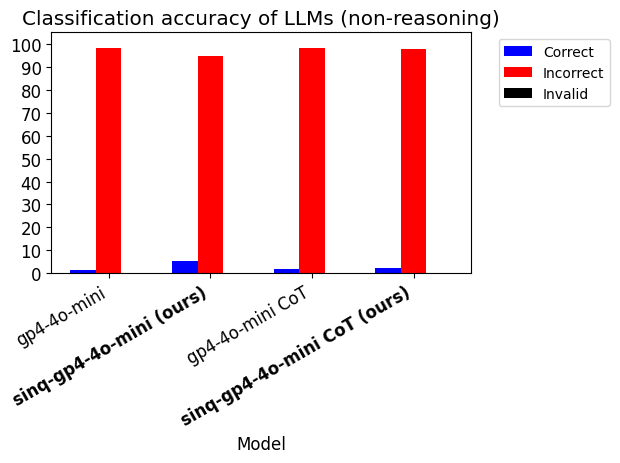

In [243]:
title = "Classification accuracy of LLMs (non-reasoning)"

model_ids = {
    "gpt-4o-mini-2024-07-18": "gp4-4o-mini",
    "ft:gpt-4o-mini-2024-07-18:uedin:semantic-inequiv-bob-run-0-round-6-generation-0:AyS2gJFd": "sinq-gp4-4o-mini (ours)",
    "cot_gpt-4o-mini-2024-07-18": "gp4-4o-mini CoT",
    "cot_ft:gpt-4o-mini-2024-07-18:uedin:semantic-inequiv-bob-run-0-round-6-generation-0:AyS2gJFd": "sinq-gp4-4o-mini CoT (ours)"
}

selected_eval_results = select_results(eval_results, model_ids)

model_names_succinct = list(selected_eval_results.keys()) #["-".join(model_name.split("-")[:-1]) for model_name in selected_eval_results.keys()]
ind = np.arange(len(model_names_succinct))
width = 0.25

pos_vals = [100.0 * selected_eval_results[model_name]['total_accuracy'] for model_name in selected_eval_results.keys()]
plt.bar(ind, pos_vals, width, label='Correct', color='blue')

neg_vals = [100.0 * (selected_eval_results[model_name]['num_examples'] - selected_eval_results[model_name]['raw_total_accuracy']) / selected_eval_results[model_name]['num_examples'] for model_name in selected_eval_results.keys()]
plt.bar(ind+width, neg_vals, width, label='Incorrect', color='red')

invalid_vals = [100.0 * (1.0 - (selected_eval_results[model_name]['num_valid'] / selected_eval_results[model_name]['num_examples'])) for model_name in selected_eval_results.keys()]
plt.bar(ind+2*width, invalid_vals, width, label='Invalid', color='black')

plt.xlabel("Model")
plt.title(title)
plt.ylim([0, 105])
plt.yticks(range(0, 110, 10))
plt.xticks(ind + (width), model_names_succinct, rotation=30, ha='right')
ax = plt.gca()
for label in ax.get_xticklabels():
    if "(ours)" in  label.get_text():
        label.set_fontweight("bold")
plt.draw()
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()

plt.savefig(Path("./", "chat_llms_classsification_plot.svg"), format="svg")
plt.savefig(Path("./", "chat_llms_classsification_plot.png"), format="png")
plt.savefig(Path("./", "chat_llms_classsification_plot.pdf"), format="pdf")

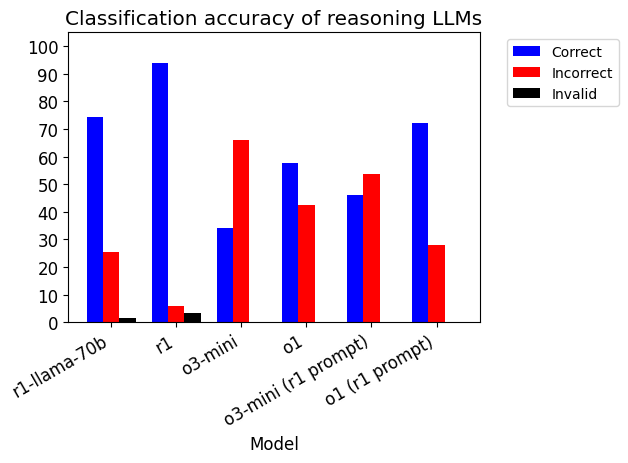

In [241]:
title = "Classification accuracy of reasoning LLMs"

model_ids = {
    "deepseek-r1-distill-llama-70b": "r1-llama-70b",
    "deepseek-r1": "r1",
    "o3-mini-2025-01-31": "o3-mini",
    "o1-2024-12-17": "o1",
    "ds_o3-mini-2025-01-31": "o3-mini (r1 prompt)",
    "ds_o1-2024-12-17": "o1 (r1 prompt)"
}

selected_eval_results = select_results(eval_results, model_ids)

model_names_succinct = list(selected_eval_results.keys()) #["-".join(model_name.split("-")[:-1]) for model_name in selected_eval_results.keys()]
ind = np.arange(len(model_names_succinct))
width = 0.25

pos_vals = [100.0 * selected_eval_results[model_name]['total_accuracy'] for model_name in selected_eval_results.keys()]
plt.bar(ind, pos_vals, width, label='Correct', color='blue')

neg_vals = [100.0 * (selected_eval_results[model_name]['num_examples'] - selected_eval_results[model_name]['raw_total_accuracy']) / selected_eval_results[model_name]['num_examples'] for model_name in selected_eval_results.keys()]
plt.bar(ind+width, neg_vals, width, label='Incorrect', color='red')

invalid_vals = [100.0 * (1.0 - (selected_eval_results[model_name]['num_valid'] / selected_eval_results[model_name]['num_examples'])) for model_name in selected_eval_results.keys()]
plt.bar(ind+2*width, invalid_vals, width, label='Invalid', color='black')

plt.xlabel("Model")
plt.title(title)
plt.ylim([0, 105])
plt.yticks(range(0, 110, 10))
plt.xticks(ind + (width), model_names_succinct, rotation=30, ha='right')
ax = plt.gca()
for label in ax.get_xticklabels():
    if "(ours)" in  label.get_text():
        label.set_fontweight("bold")
plt.draw()
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()

plt.savefig(Path("./", "chat_llms_reasoning_classsification_plot.svg"), format="svg")
plt.savefig(Path("./", "chat_llms_reasoning_classsification_plot.png"), format="png")
plt.savefig(Path("./", "chat_llms_reasoning_classsification_plot.pdf"), format="pdf")

In [13]:
eval_results

{'gpt-4o-mini-2024-07-18': {'raw_total_accuracy': 33,
  'total_accuracy': 0.0165,
  'total_accuracy_on_valid': 0.0165,
  'num_valid': 2000,
  'num_examples': 2000},
 'ft:gpt-4o-mini-2024-07-18:uedin:semantic-inequiv-bob-run-0-round-6-generation-0:AyS2gJFd': {'raw_total_accuracy': 107,
  'total_accuracy': 0.0535,
  'total_accuracy_on_valid': 0.0535,
  'num_valid': 2000,
  'num_examples': 2000},
 'cot_gpt-4o-mini-2024-07-18': {'raw_total_accuracy': 38,
  'total_accuracy': 0.019,
  'total_accuracy_on_valid': 0.019,
  'num_valid': 2000,
  'num_examples': 2000},
 'cot_ft:gpt-4o-mini-2024-07-18:uedin:semantic-inequiv-bob-run-0-round-6-generation-0:AyS2gJFd': {'raw_total_accuracy': 46,
  'total_accuracy': 0.023,
  'total_accuracy_on_valid': 0.023,
  'num_valid': 2000,
  'num_examples': 2000},
 'o3-mini-2025-01-31': {'raw_total_accuracy': 682,
  'total_accuracy': 0.341,
  'total_accuracy_on_valid': 0.341,
  'num_valid': 2000,
  'num_examples': 2000},
 'o1-2024-12-17': {'raw_total_accuracy': 11

In [244]:
from IPython.display import Image

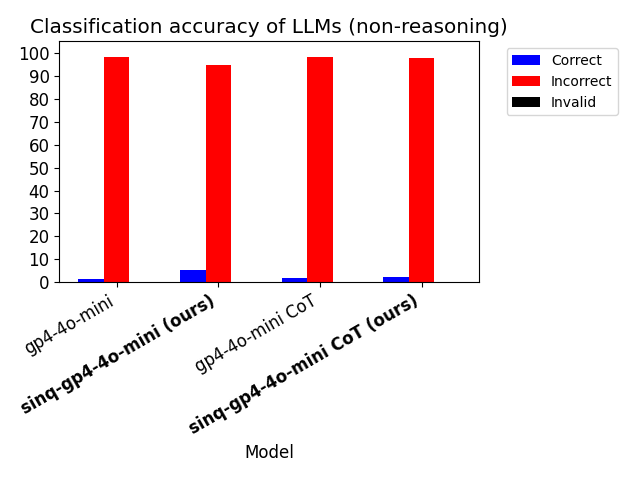

In [245]:
Image("./chat_llms_classsification_plot.png")